In [ ]:
# !python -m spacy download da_core_news_sm

In [75]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
import numpy as np
import krippendorff
import os
from wordcloud import WordCloud
import os
import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
#ignore future warnings and user warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [76]:
# Loading the data
train_df = pd.read_csv('data/train_new.csv')
val_df = pd.read_csv('data/val_new.csv')
test_df = pd.read_csv('data/test_new.csv')

X_train = train_df['article_bert']
y_train = train_df['articles_constructive']
X_val = val_df['article_bert']
y_val = val_df['articles_constructive']
X_test = test_df['article_bert']
y_test = test_df['articles_constructive']

In [83]:
import re
from spacy.lang.da import Danish
from spacy.lang.da.stop_words import STOP_WORDS
import string
import spacy
from sklearn.base import TransformerMixin

punctuations = string.punctuation
nlp = spacy.load('da_core_news_sm')

def remove_html_elements(corpus):
    if corpus != None:
        html = re.compile(r'<.*?>')
        html = html.sub(r' ',corpus)
        html = html.replace("&nbsp;", " ")
        html = html.replace("&amp;", "og")
        return html

def remove_extra_spaces(input_string):
    output_string = []
    space_flag = False # Flag to check if spaces have occurred

    if input_string != None:        
        for index in range(len(input_string)):
            if input_string[index] != ' ':
                if space_flag == True:
                    if (input_string[index] == '.'
                            or input_string[index] == '?'
                            or input_string[index] == ','):
                        pass
                    else:
                        output_string.append(' ')
                    space_flag = False
                output_string.append(input_string[index])
            elif input_string[index - 1] != ' ':
                space_flag = True

    return ''.join(output_string)

#nlp = spacy.load('da_core_news_sm')

#punctuations = string.punctuation

# Creating our tokenizer function
def spacy_tokenizer(sentence):

    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in STOP_WORDS and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [84]:
# Call remove_html_elements function and remove_extra_spaces function on X_train, X_val and X_test
X_train = X_train.apply(remove_html_elements)
X_train = X_train.apply(remove_extra_spaces)
X_val = X_val.apply(remove_html_elements)
X_val = X_val.apply(remove_extra_spaces)
X_test = X_test.apply(remove_html_elements)
X_test = X_test.apply(remove_extra_spaces)

# For training of final models
X_train_final = X_train.append(X_val)
y_train_final = y_train.append(y_val)

In [85]:
# Vectorization
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [87]:
# Logistic Regression Classifier
log_classifier = LogisticRegression(random_state=42)

# Create pipeline using Bag of Words
log_pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector), # bow_vector or tfidf_vector
                 ('classifier', log_classifier)])

# Fitting
log_pipe.fit(X_train_final, y_train_final)

# Predicting
log_predicted = log_pipe.predict(X_test)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,log_predicted).ravel()

# Model Accuracy
print(f'Logistic Regression Accuracy: {round(accuracy_score(y_test,log_predicted),4)*100}%')
print(f'Logistic Regression Precision: {round(precision_score(y_test,log_predicted),4)*100}%')
print(f'Logistic Regression Recall: {round(recall_score(y_test,log_predicted),4)*100}%')
print(f'Logistic Regression Confusion Matrix: \n True Positive: {tp} \n False Positive: {fp} \n False Negative: {fn} \n True Negative: {tn}')
# print(f'Logistic Regression Confusion Matrix: \n{confusion_matrix(y_test,predicted)}')

# Creating dataframe with mislabelled articles
mislabelled_logreg = pd.DataFrame(columns=['article', 'predicted', 'actual'])
for article, prediction, label in zip(X_test, log_predicted, y_test):
  if prediction != label:
    mislabelled_logreg = mislabelled_logreg.append({'article': article, 'predicted': prediction, 'actual': label}, ignore_index=True)

Logistic Regression Accuracy: 83.33%
Logistic Regression Precision: 76.67%
Logistic Regression Recall: 95.83%
Logistic Regression Confusion Matrix: 
 True Positive: 23 
 False Positive: 7 
 False Negative: 1 
 True Negative: 17


In [88]:
mislabelled_logreg

,article,predicted,actual
0,Skal nullermænd gøres kønsneutrale? Her er et ...,True,False
1,Fynske talenter vinder for årets danske kortfi...,True,False
2,Minister: Nye skattecentre på Fyn skal jagte s...,True,False
3,Mistænker drikkevandet er forurenet: Vandet sk...,True,False
4,Det giftige PFOS har spredt sig i Seden: - Ing...,True,False
5,Fyns Politi filmer de forkerte steder: Kamerao...,False,True
6,Se møde mellem mor til syg dreng og borgmester...,True,False
7,Bo kender Svendborgs grusomme historier - og n...,True,False


In [89]:
logreg_coef = log_pipe.get_params()['classifier'].coef_[0]

In [90]:
tfidf_mapping = log_pipe.get_params()['vectorizer'].vocabulary_
tfidf_map=[(x,tfidf_mapping[x]) for x in tfidf_mapping]
tfidf_map[:10]
tfidf_map.sort(key=lambda x: x[1])
log_vocab=[x[0] for x in tfidf_map]
log_coef_df = pd.DataFrame(list(zip(log_vocab, logreg_coef)), columns=["word", "coef"])

In [91]:
# Most constructive words
log_coef_df.sort_values(by='coef', ascending=False).head(20)

,word,coef
4290,kommune,0.729430
8581,ung,0.531266
2036,elev,0.492571
5467,natur,0.462449
3479,hjælpe,0.402454
9040,år,0.392212
4425,krig,0.367374
7522,strand,0.353569
2656,forslag,0.343521
8370,uddannelse,0.334719


In [92]:
# Least constructive words
log_coef_df.sort_values(by='coef', ascending=True).head(20)

,word,coef
6223,politi,-0.918985
8755,vejr,-0.594606
5022,løb,-0.474387
5702,ob,-0.459290
6503,regn,-0.445546
7885,temperatur,-0.432400
5820,onsdag,-0.428338
5041,lørdag,-0.403086
9154,øvelse,-0.372404
4050,kamp,-0.355592


In [93]:
# Gradient Boosting Classifier - Baseline
classifier = GradientBoostingClassifier(random_state=42)

# Create pipeline using Bag of Words
gb_pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

# Fitting
gb_pipe.fit(X_train_final, y_train_final)

# Predicting
gb_predicted = gb_pipe.predict(X_test)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,gb_predicted).ravel()

# Model Accuracy
print(f'Gradient Boosting Accuracy: {round(accuracy_score(y_test,gb_predicted),4)*100}%')
print(f'Gradient Boosting Precision: {round(precision_score(y_test,gb_predicted),4)*100}%')
print(f'Gradient Boosting Recall: {round(recall_score(y_test,gb_predicted),4)*100}%')
print(f'Gradient Boosting Confusion Matrix: \n True Positive: {tp} \n False Positive: {fp} \n False Negative: {fn} \n True Negative: {tn}')
# print(f'Gradient Boosting Confusion Matrix: \n{confusion_matrix(y_test,predicted)}')

# Creating dataframe with mislabelled articles
mislabelled_gbt = pd.DataFrame(columns=['article', 'predicted', 'actual'])
for article, prediction, label in zip(X_test, gb_predicted, y_test):
  if prediction != label:
    if prediction == 0:
      prediction = False
    if prediction == 1:
      prediction = True
    mislabelled_gbt = mislabelled_gbt.append({'article': article, 'predicted': prediction, 'actual': label}, ignore_index=True)

Gradient Boosting Accuracy: 79.17%
Gradient Boosting Precision: 76.92%
Gradient Boosting Recall: 83.33%
Gradient Boosting Confusion Matrix: 
 True Positive: 20 
 False Positive: 6 
 False Negative: 4 
 True Negative: 18


In [94]:
mislabelled_gbt

,article,predicted,actual
0,"Her er fire råd, der kan beskytte dig mod over...",False,True
1,Fynske talenter vinder for årets danske kortfi...,True,False
2,Onsdag genåbner Vollsmose: - Vi glæder os rigt...,False,True
3,Minister: Nye skattecentre på Fyn skal jagte s...,True,False
4,Det giftige PFOS har spredt sig i Seden: - Ing...,True,False
5,Læge idømt stor bøde for at smide lægejournale...,True,False
6,Vand trængte ind under mur - men beboere ånder...,True,False
7,Overlæge på OUH: - Vi skal bruge dobbelt så ma...,False,True
8,"Et kæmpe tab for OL, men en lille fordel for o...",True,False
9,Børns Vilkår: Sådan kan du tale med dit barn o...,False,True


In [ ]:
# # Gradient Boosting Classifier with hyperparameter tuning

# n_estimators_list = [10,15,50,100,200,250]
# min_samples_split_list = [2,3,4,5,10,20,30]
# min_samples_leaf_list = [1,2,3,4,5,2,3,4,5,10,20,30]

# results = []

# for n_estimators in n_estimators_list:
#     for min_samples_split in min_samples_split_list:
#         for min_samples_leaf in min_samples_leaf_list:
#             gbt_current = GradientBoostingClassifier(
#                 n_estimators=n_estimators,
#                 min_samples_split=min_samples_split,
#                 min_samples_leaf=min_samples_leaf,
#                 )
#             pipe = Pipeline([("cleaner", predictors()),
#                              ('vectorizer', tfidf_vector),
#                              ('classifier', gbt_current)])
#             pipe.fit(X_train, y_train)
#             y_val_hat_gb_tuner = pipe.predict(X_val)
#             acc = accuracy_score(y_val, y_val_hat_gb_tuner)

#             results.append([acc, n_estimators, min_samples_split, min_samples_leaf])

# results = pd.DataFrame(results)
# results.columns = ['Accuracy', 'n_estimators', 'min_samples_split', 'min_samples_leaf']
# print(results)

In [ ]:
# # Extract best parameters
# results[results['Accuracy'] == results['Accuracy'].max()]

In [95]:
# Optimized Gradien Boost Classifier
gb_optimized = GradientBoostingClassifier(
                n_estimators=200,
                min_samples_split=30,
                min_samples_leaf=2,
                random_state=42
                )

# Create pipeline using TF-IDF
gb_op_pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', gb_optimized)])

# Fitting
gb_op_pipe.fit(X_train_final, y_train_final)

# Predicting
gb_op_predicted = gb_op_pipe.predict(X_test)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,gb_op_predicted).ravel()

# Obtain and check accuracy on test data
print(f'Optimized Gradient Boosting Accuracy: {round(accuracy_score(y_test,gb_op_predicted),4)*100}%')
print(f'Optimized Gradient Boosting Precision: {round(precision_score(y_test,gb_op_predicted),4)*100}%')
print(f'Optimized Gradient Boosting Recall: {round(recall_score(y_test,gb_op_predicted),4)*100}%')
print(f'Optimized Gradient Boosting Confusion Matrix: \n True Positive: {tp} \n False Positive: {fp} \n False Negative: {fn} \n True Negative: {tn}')

# Creating dataframe with mislabelled articles
mislabelled_gb_optimized = pd.DataFrame(columns=['article', 'predicted', 'actual'])
for article, prediction, label in zip(X_test, gb_op_predicted, y_test):
  if prediction != label:
    if prediction == 0:
      prediction = False
    if prediction == 1:
      prediction = True
    mislabelled_gb_optimized = mislabelled_gb_optimized.append({'article': article, 'predicted': prediction, 'actual': label}, ignore_index=True)

Optimized Gradient Boosting Accuracy: 79.17%
Optimized Gradient Boosting Precision: 79.17%
Optimized Gradient Boosting Recall: 79.17%
Optimized Gradient Boosting Confusion Matrix: 
 True Positive: 19 
 False Positive: 5 
 False Negative: 5 
 True Negative: 19


In [96]:
mislabelled_gb_optimized

,article,predicted,actual
0,"Her er fire råd, der kan beskytte dig mod over...",False,True
1,Onsdag genåbner Vollsmose: - Vi glæder os rigt...,False,True
2,Minister: Nye skattecentre på Fyn skal jagte s...,True,False
3,Mistænker drikkevandet er forurenet: Vandet sk...,True,False
4,Det giftige PFOS har spredt sig i Seden: - Ing...,True,False
5,Læge idømt stor bøde for at smide lægejournale...,True,False
6,Vand trængte ind under mur - men beboere ånder...,True,False
7,Overlæge på OUH: - Vi skal bruge dobbelt så ma...,False,True
8,- De har forlænget mit liv: Steen fik afslag p...,False,True
9,Børns Vilkår: Sådan kan du tale med dit barn o...,False,True


In [97]:
# Random Forest Classifier - Baseline
classifier = RandomForestClassifier(random_state=42)

# Create pipeline
rf_pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector), # bow_vector or tfidf_vector
                 ('classifier', classifier)])

# Fitting
rf_pipe.fit(X_train_final, y_train_final)

# Predicting
rf_predicted = rf_pipe.predict(X_test)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,rf_predicted).ravel()

# Model Accuracy
print(f'Random Forest Accuracy: {round(accuracy_score(y_test,rf_predicted),4)*100}%')
print(f'Random Forest Precision: {round(precision_score(y_test,rf_predicted),4)*100}%')
print(f'Random Forest Recall: {round(recall_score(y_test,rf_predicted),4)*100}%')
print(f'Random Forest Confusion Matrix: \n True Positive: {tp} \n False Positive: {fp} \n False Negative: {fn} \n True Negative: {tn}')

# Creating dataframe with mislabelled articles
mislabelled_rf = pd.DataFrame(columns=['article', 'predicted', 'actual'])
for article, prediction, label in zip(X_test, rf_predicted, y_test):
  if prediction != label:
    if prediction == 0:
      prediction = False
    if prediction == 1:
      prediction = True
    mislabelled_rf = mislabelled_rf.append({'article': article, 'predicted': prediction, 'actual': label}, ignore_index=True)

Random Forest Accuracy: 89.58%
Random Forest Precision: 85.19%
Random Forest Recall: 95.83%
Random Forest Confusion Matrix: 
 True Positive: 23 
 False Positive: 4 
 False Negative: 1 
 True Negative: 20


In [98]:
mislabelled_rf

,article,predicted,actual
0,Skal nullermænd gøres kønsneutrale? Her er et ...,True,False
1,Fynske talenter vinder for årets danske kortfi...,True,False
2,Onsdag genåbner Vollsmose: - Vi glæder os rigt...,False,True
3,Minister: Nye skattecentre på Fyn skal jagte s...,True,False
4,Se møde mellem mor til syg dreng og borgmester...,True,False


In [ ]:
# # Optimizing Random Forest

# # Select parameters to tune
# min_samples_split_list = [2,3,4,6,8,10,12,20,25] 
# min_samples_leaf_list = [1,2,4,6,8,10,12,20,25] 
# max_features_list = [None, 2,4,6,8,10,12,15,20,50,100,180,200,220,250]

# # Create empty list to store results
# results = []

# for min_samples_split in min_samples_split_list:
#     for min_samples_leaf in min_samples_leaf_list:
#         for max_features in max_features_list:
#             rf_current = RandomForestClassifier(
#                 min_samples_split=min_samples_split,
#                 min_samples_leaf=min_samples_leaf,
#                 max_features=max_features,
#                 random_state=42
#                 )
#             pipe = Pipeline([("cleaner", predictors()),
#                              ('vectorizer', tfidf_vector),
#                              ('classifier', rf_current)])
#             pipe.fit(X_train,y_train)
#             y_val_hat_RF_tuner = pipe.predict(X_val)
#             accuracy = accuracy_score(y_val_hat_RF_tuner,y_val)

#             results.append([accuracy, min_samples_split, min_samples_leaf, max_features])


# results = pd.DataFrame(results)
# results.columns = ['Accuracy', 'min_samples_split', 'min_samples_leaf', 'max_features']
# print(results)

In [ ]:
# # Extract best parameters.
# results[results['Accuracy'] == results['Accuracy'].max()]

In [99]:
# RF with optimized parameters
rf_optimized = RandomForestClassifier(
    min_samples_split=4,
    min_samples_leaf=6,
    max_features=50,
    random_state=42
    )

# Create pipeline
rf_op_pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', rf_optimized)])

# Fitting
rf_op_pipe.fit(X_train_final, y_train_final)

# Predicting
rf_op_predicted = rf_op_pipe.predict(X_test)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,rf_op_predicted).ravel()

# Obtain and check accuracy on val data
print(f'Optimized Random Forest Accuracy: {round(accuracy_score(y_test,rf_op_predicted),4)*100}%')
print(f'Optimized Random Forest Precision: {round(precision_score(y_test,rf_op_predicted),4)*100}%')
print(f'Optimized Random Forest Recall: {round(recall_score(y_test,rf_op_predicted),4)*100}%')
print(f'Optimized Random Forest Confusion Matrix: \n True Positive: {tp} \n False Positive: {fp} \n False Negative: {fn} \n True Negative: {tn}')

# Creating dataframe with mislabelled articles
mislabelled_rf_optimized = pd.DataFrame(columns=['article', 'predicted', 'actual'])
for article, prediction, label in zip(X_test, rf_op_predicted, y_test):
  if prediction != label:
    if prediction == 0:
      prediction = False
    if prediction == 1:
      prediction = True
    mislabelled_rf_optimized = mislabelled_rf_optimized.append({'article': article, 'predicted': prediction, 'actual': label}, ignore_index=True)

Optimized Random Forest Accuracy: 77.08%
Optimized Random Forest Precision: 76.0%
Optimized Random Forest Recall: 79.17%
Optimized Random Forest Confusion Matrix: 
 True Positive: 19 
 False Positive: 6 
 False Negative: 5 
 True Negative: 18


In [100]:
mislabelled_rf_optimized

,article,predicted,actual
0,Skal nullermænd gøres kønsneutrale? Her er et ...,True,False
1,Fynske talenter vinder for årets danske kortfi...,True,False
2,Onsdag genåbner Vollsmose: - Vi glæder os rigt...,False,True
3,Minister: Nye skattecentre på Fyn skal jagte s...,True,False
4,Beboere frygter for naturområde: Byggeplaner v...,False,True
5,Mistænker drikkevandet er forurenet: Vandet sk...,True,False
6,Det giftige PFOS har spredt sig i Seden: - Ing...,True,False
7,Misser Black Friday efter million-tyveri: - Vi...,True,False
8,Fyns Politi filmer de forkerte steder: Kamerao...,False,True
9,Trodser vejr og corona: - Jeg glæder mig helt ...,False,True


In [101]:
# SVM Classifier
# Validated on kernels and vectorizers

svm_classifier = svm.SVC(kernel = 'poly', random_state=42)

# Create pipeline
svm_pipe = Pipeline([("cleaner", predictors()),
                ('vectorizer', tfidf_vector), # bow_vector or tfidf_vector (tfidf_vector virker bedst)
                ('classifier', svm_classifier)])

# model generation
svm_pipe.fit(X_train_final, y_train_final)

# Predicting with a test dataset
svm_predicted = svm_pipe.predict(X_test)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,svm_predicted).ravel()

# Model Accuracy
print(f'SVM Accuracy: {round(accuracy_score(y_test,svm_predicted),4)*100}%')
print(f'SVM Precision: {round(precision_score(y_test,svm_predicted),4)*100}%')
print(f'SVM Recall: {round(recall_score(y_test,svm_predicted),4)*100}%')
print(f'SVM Confusion Matrix: \n True Positive: {tp} \n False Positive: {fp} \n False Negative: {fn} \n True Negative: {tn}')
print('\n\n\n')

SVM Accuracy: 75.0%
SVM Precision: 70.0%
SVM Recall: 87.5%
SVM Confusion Matrix: 
 True Positive: 21 
 False Positive: 9 
 False Negative: 3 
 True Negative: 15






In [102]:
# Creating dataframe with mislabelled articles
mislabelled_svm = pd.DataFrame(columns=['article', 'predicted', 'actual'])
for article, prediction, label in zip(X_test, svm_predicted, y_test):
  if prediction != label:
    if prediction == 0:
      prediction = False
    if prediction == 1:
      prediction = True
    mislabelled_svm = mislabelled_svm.append({'article': article, 'predicted': prediction, 'actual': label}, ignore_index=True)

In [103]:
mislabelled_svm

,article,predicted,actual
0,"Her er fire råd, der kan beskytte dig mod over...",False,True
1,Skal nullermænd gøres kønsneutrale? Her er et ...,True,False
2,- Brentfords håb om at overtale Eriksen vil sa...,True,False
3,Fynske talenter vinder for årets danske kortfi...,True,False
4,Mindste klasser plantede skolegårdsskov: - Nu ...,False,True
5,Minister: Nye skattecentre på Fyn skal jagte s...,True,False
6,Mistænker drikkevandet er forurenet: Vandet sk...,True,False
7,Det giftige PFOS har spredt sig i Seden: - Ing...,True,False
8,Vand trængte ind under mur - men beboere ånder...,True,False
9,Fyns Politi filmer de forkerte steder: Kamerao...,False,True


In [104]:
rf_coef = rf_pipe.get_params()['classifier'].feature_importances_

In [105]:
rf_tfidf_mapping = rf_pipe.get_params()['vectorizer'].vocabulary_
rf_tfidf_map=[(x,tfidf_mapping[x]) for x in tfidf_mapping]
rf_tfidf_map[:10]
rf_tfidf_map.sort(key=lambda x: x[1])
rf_vocab=[x[0] for x in tfidf_map]
rf_coef_df = pd.DataFrame(list(zip(rf_vocab, rf_coef)), columns=["word", "coef"])

In [106]:
# Most constructive words
rf_coef_df.sort_values(by='coef', ascending=False).head(40)

,word,coef
640,al,0.012814
8581,ung,0.008301
5022,løb,0.007765
5647,når,0.007071
4290,kommune,0.006626
4456,krone,0.006211
9040,år,0.006060
3478,hjælp,0.006018
2966,føre,0.005809
3096,glad,0.005801


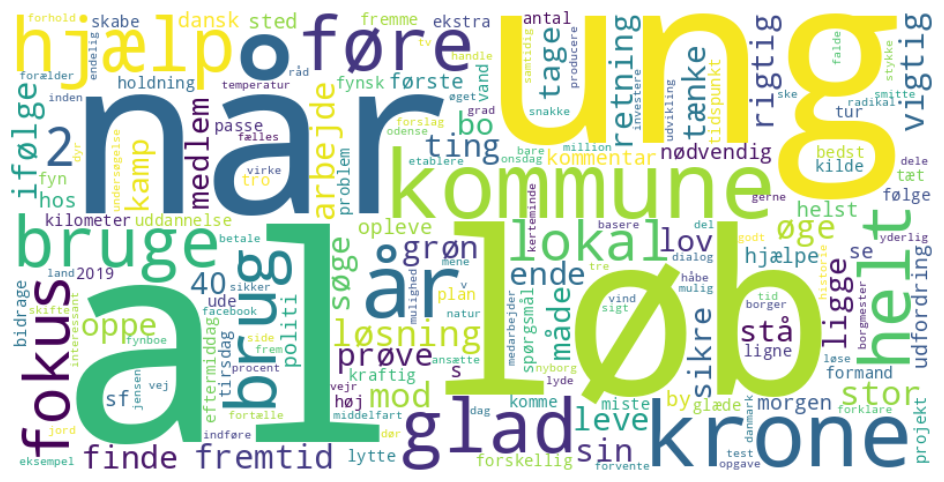

In [107]:
# WordCloud for Random Forest
coef_list = list(zip(rf_vocab, rf_coef))
coef_dict = {x[0]: x[1] for x in coef_list}

# WordCloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white', min_font_size = 10)

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize = (12, 6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()
#wordcloud.to_file("random_forest_wordcloud.png")

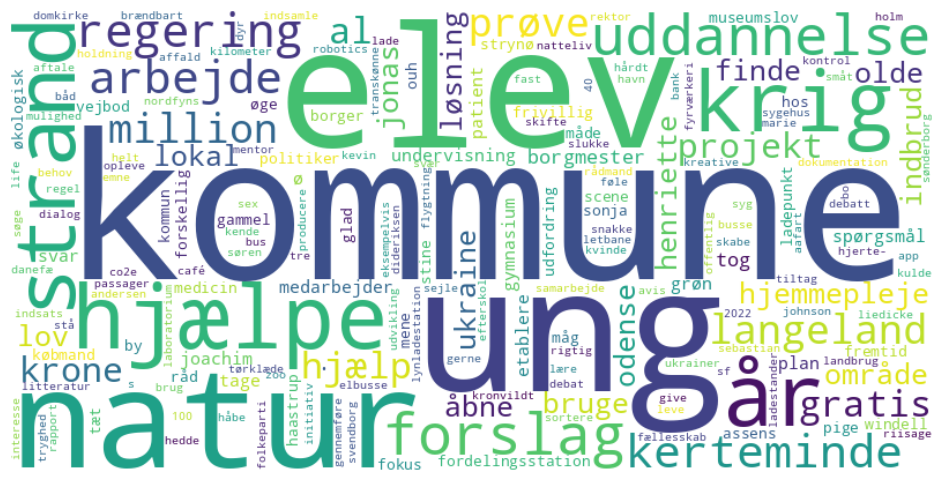

In [108]:
# WordCloud for Logistic Regression - Constructive Words
coef_list = list(zip(log_vocab, logreg_coef))
coef_dict = {x[0]: x[1] for x in coef_list}

# WordCloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white', min_font_size = 10)

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize = (12, 6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()
#wordcloud.to_file("log_reg_constructive_wordcloud.png")

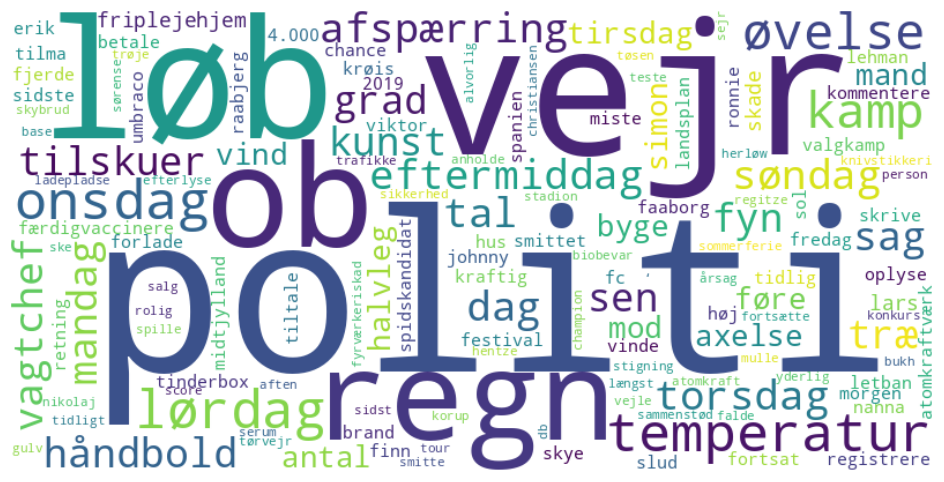

In [109]:
# WordCloud for Logistic Regression - Non-Constructive Words
coef_list = list(zip(log_vocab, logreg_coef*-1))
coef_dict = {x[0]: x[1] for x in coef_list}

# WordCloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white', min_font_size = 10)

wordcloud.generate_from_frequencies(coef_dict)

plt.figure(figsize = (12, 6))
plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")
plt.show()
#wordcloud.to_file("log_reg_NON_constructive_wordcloud.png")

In [ ]:
# =============================================================================
#                      LIME Explainer for single article
# =============================================================================

In [115]:
# LIME explainer for best model (Vanilla Random Forest)
idx = 12 # Change this to check other articles
class_names=['Not constructive', 'Constructive']
explainer = LimeTextExplainer(class_names=class_names)
# Read the chosen article
X_test[idx] # Article

'Mødrehjælpen efterspørger donationer: Har du konfirmationstøj hængende i skabet? Skab Event og Mødrehjælpen i Svendborg samler brugt konfirmationstøj ind, så nye konfirmander kan få glæde af det til et gratis event. Konfirmation handler om at bekræfte sin dåb, men for mange unge handler det også om konfirmationstøj, transport fra kirken og dyre gaver. Alle ting, der kan gøre en konfirmation dyr, og som ikke alle familier har råd til. Derfor har mødrehjælpen i Svendborg sammen med den svendborgensiske virksomhed Skab Event valgt at samle brugt konfirmationstøj ind, som økonomisk pressede familier kan få glæde af. - Vi vil gerne give familier mulighed for at få for eksempel en god konfirmationskjole. Det er en dyr ting at skulle ud at købe, siger Dorthe Bang, der er formand for Mødrehjælpens lokalforening i Svendborg. Skab Event og Mødrehjælpens indsamling skal ende ud i et event for kommende konfirmander og deres familier med fokus på genbrug og bæredygtighed. Afhængig af donationer Al

In [116]:
exp = explainer.explain_instance(X_test[idx], rf_pipe.predict_proba, num_features=30)
print('Document id: %d' % idx)
print('Probability(constructive) =', rf_pipe.predict_proba([X_test[idx]])[0,1])
print('True class: %s' % class_names[y_test[idx]])

Document id: 12
Probability(constructive) = 0.68
True class: Constructive


/tmp/ipykernel_27621/3562108140.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print('True class: %s' % class_names[y_test[idx]])


In [117]:
# Probabilities of the article being constructive or not
print(rf_pipe.predict_proba([X_test.iloc[idx]])) 

[[0.32 0.68]]


In [ ]:
# Save the explainer to html file
folder_path = ''
exp.show_in_notebook(text=True)

file_name = f"explainer{idx}.html"
file_path = os.path.join(folder_path, file_name)

# save the explainer to html file
#exp.save_to_file(file_path)

In [118]:
exp.as_list()

[('unge', 0.055925913933718006),
 ('ende', -0.03368086466888192),
 ('fokus', 0.027188334141045597),
 ('ting', 0.025794243391795785),
 ('lignende', 0.024426766551763103),
 ('leve', 0.020898016368712788),
 ('forældre', 0.019074174592936286),
 ('glæde', 0.018330797212637945),
 ('lokal', 0.018221935570745668),
 ('rigtig', 0.016977597390247998),
 ('råd', 0.0168466366109473),
 ('opfordre', 0.015623519719939903),
 ('søger', 0.01414264966806151),
 ('søge', 0.013615082674062513),
 ('finde', 0.013225538978605874),
 ('overveje', 0.013171413884341114),
 ('formand', 0.013137863950837107),
 ('handler', 0.012290638629011965),
 ('hjælpe', 0.012273828462704339),
 ('dyr', 0.012187236305970656),
 ('købe', -0.011830571174617442),
 ('liv', -0.01106471591590623),
 ('midler', 0.010492470517138827),
 ('Svendborg', 0.010082571001953526),
 ('eksempel', 0.010000663890092598),
 ('gerne', 0.009030466800709382),
 ('brugt', 0.008638227705824541),
 ('grad', -0.0077389913997371815),
 ('valgt', -0.00676465645267715),
 

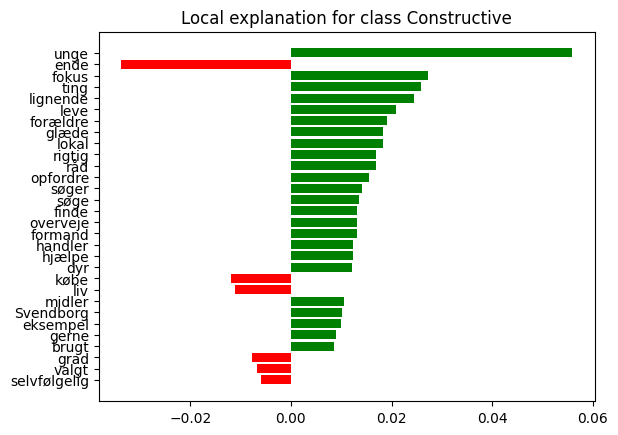

In [120]:
%matplotlib inline
# plot top 20 features as_pyplot_figure
fig = exp.as_pyplot_figure()

# Define the folder where you want to save the plot
folder_path = f"explanations/{idx}/"

# Make sure the folder exists, if not, create it
os.makedirs(folder_path, exist_ok=True)

# Define the filename and the full path where you want to save the plot
filename = f"fig{idx}.png"
file_path = os.path.join(folder_path, filename)

# Save the figure in the specified folder and filename
#fig.savefig(file_path)

In [121]:
exp.show_in_notebook(text=True)

In [ ]:
# Define the folder where you want to save the plot
folder_path = f"/tmp/explanations/{idx}"

# Make sure the folder exists, if not, create it
os.makedirs(folder_path, exist_ok=True)

# Define the filename and the full path where you want to save the plot
file_name = f"explainer{idx}.html"
file_path = os.path.join(folder_path, file_name)

# Save the figure in the specified folder and filename
exp.save_to_file(file_path)

In [ ]:
# =============================================================================
#                      LIME Explainer for multiple articles
# =============================================================================

# Saves explanations in the range of idx_list to html files, the top features as plots and prediction probabilities in a folder structure

idx_list = range(0, 47)

for idx in idx_list:
    class_names=['Not constructive', 'Constructive']
    exp = explainer.explain_instance(X_test[idx], rf_pipe.predict_proba, num_features=30)
    # plot top 20 features as_pyplot_figure
    fig = exp.as_pyplot_figure()

    # Define the folder where you want to save the plot
    folder_path = f"explanations/{idx}/"

    # Make sure the folder exists, if not, create it
    os.makedirs(folder_path, exist_ok=True)

    # Define the filename and the full path where you want to save the plot
    filename = f"fig{idx}.png"
    file_path = os.path.join(folder_path, filename)

    # Save the figure in the specified folder and filename
    fig.savefig(file_path)

    # Save true class and class probability to text file
    file_name_txt = f"true_class{idx}.txt"
    file_path = os.path.join(folder_path, file_name_txt)

    with open(file_path, 'w') as file:
        file.write('Document id: %d\n' % idx)
        file.write('Probability(constructive) = %f\n' % rf_pipe.predict_proba([X_test[idx]])[0,1])
        file.write('True class: %s' % class_names[y_test[idx]])

    # Save the explainer to html file
    exp.show_in_notebook(text=True)

    file_name = f"explainer{idx}.html"
    file_path = os.path.join(folder_path, file_name)

    exp.save_to_file(file_path)

In [122]:
# Analysis tool for evaluating frequency of words in constructive and non-constructive articles

# word to search for longer words !!
word = ' unge '
search_word = word

# # search for short/not unique words !!
# search_word = 'steen'
# word = r'\b' + re.escape(search_word) + r"(?=[\s.])"
# r"(?<![a-zA-Z])" + re.escape(search_word) + r"(?=[\s.])"


# dataset to search in
data = 'train_new'  
dataset = f'{data}.csv'
df = pd.read_csv(f'data/{dataset}', index_col=0)

data2 = 'val_new' # dataset to search in
dataset2 = f'{data2}.csv'
df_extra = pd.read_csv(f'data/{dataset2}', index_col=0)

df = pd.concat([df, df_extra])

df['article_bert'] = df['article_bert'].str.lower()
df['labels'] = df['articles_constructive'].astype(int)
del df_extra


# Frequency of constructive and non-constructive articles that contains ''
word_select = df.loc[df['article_bert'].str.contains(word)]
word_select_non_constructive = word_select['labels'].value_counts()[0]
word_select_constructive = word_select['labels'].value_counts()[1]

# concatenate all text in df_filtered
text = ' '.join(df[df['labels'] == 0]['article_bert'])
matches = re.findall(word, text)
count = len(matches)
#count = text.count(word)

# count and sum 'word' in text
print(f'Among {len(df)} articles there are {word_select_non_constructive} non-constructive articles {dataset}, where {search_word} is mentioned {count} times.')

# concatenate all text in df_filtered
text = ' '.join(df[df['labels'] == 1]['article_bert'])
matches = re.findall(word, text)
count = len(matches)
#count = text.count(word)

# count and sum 'word' in text
print(f'Among {len(df)} articles there are {word_select_constructive} constructive articles in {dataset} & {dataset2}, where {search_word} is mentioned {count} times.')

Among 180 articles there are 2 non-constructive articles train_new.csv, where  unge  is mentioned 2 times.
Among 180 articles there are 20 constructive articles in train_new.csv & val_new.csv, where  unge  is mentioned 39 times.


In [123]:
df[df['article_bert'].str.contains(word)]
articles_with_word = df[df['article_bert'].str.contains(word)]['article_bert']

In [124]:
articles_with_word

article_id
106c23ae-52b2-4810-bd31-b7c88a70ee4d    nej, ældre er ikke mindre kreative end unge fa...
45b8c84e-739c-4025-9a71-c6899563a011    nana og simon søger drømmeboligen - men boligp...
0e91822e-e395-42b7-8c18-81ef6c8db5bd    strynø i finalen til årets ø: 'de ligger lunt ...
de8f670c-2251-4efe-a6c2-f8496aadc9ea    henriette er helt usædvanlig: - en sms fra bor...
6d69ea75-8d7d-4405-92c0-35f8fa90d9b5    de unge læser for lidt: nu sætter fynsk gymnas...
6514a996-a566-437b-99e5-eb39d94defa5    ny plantefestival skal få os til at købe økolo...
0932e5b7-9161-4981-8eed-62aafae1ab31    ob-anfører kalder afsked bitter efter pokalned...
b93137f6-f652-4746-a533-471157c21c66    hvem er fyns bedste kammerat? i eftermiddag ka...
669b470b-20dd-466b-8465-abcd917649e6    akut hjælp: kampen mod negativ social kontrol ...
2c10f77c-9ef1-4c62-a078-129ffb3100a6    unge dropper coronadating - men behøver man de...
88b453fe-3c4d-4795-aada-051f58ea048d    15-årige kevin finder sjældent smykke fra viki...

In [125]:
df['word_count'] = df['article_bert'].str.count(word)

In [126]:
word_count_df = df[['article_bert', 'word_count', 'labels', 'article_url']]

In [128]:
word_count_df 

,article_bert,word_count,labels,article_url
article_id,,,,
dc7bb6ab-cc83-4cd0-b31b-247c324730c7,borgmesterduel i faaborg: - jeg er ikke nødven...,0,0,https://www.tv2fyn.dk/faaborg-midtfyn/borgmest...
106c23ae-52b2-4810-bd31-b7c88a70ee4d,"nej, ældre er ikke mindre kreative end unge fa...",1,1,https://www.tv2fyn.dk/hvornaar-er-det-fyraften...
6d8ba3f6-e438-4264-b647-f7bf580f86cb,transkønnede elever efterlyser kønsneutrale væ...,0,1,https://www.tv2fyn.dk/artikel/et-anderledes-fo...
4c1b5b19-7953-41b4-9fde-cfec087b7e40,sæson skudt i gang: her kan du finde rent bade...,0,1,https://www.tv2fyn.dk/fyn/saeson-skudt-i-gang-...
276529b3-a785-4432-aeee-29ce1992c7df,incidensen tæt på 1.000: smitten stiger fortsa...,0,0,https://www.tv2fyn.dk/odense/incidensen-taet-p...
...,...,...,...,...
0de1f0a6-9446-4e9b-a700-0fe412ee703f,øredøvende larm: droner med højtryksspuler bek...,0,1,https://www.tv2fyn.dk/odense/oeredoevende-larm...
c719ed52-b8c8-46c2-905d-4d8a43833251,21-årig fremstillet i retten: formodet drabsma...,0,0,https://www.tv2fyn.dk/odense/21-aarig-fremstil...
d638b9c5-d124-4ea5-9be5-455cea56b336,valgfolkefest på langeland: se hele den store ...,0,1,https://www.tv2fyn.dk/langeland/valgfolkefest-...


In [129]:
# Load predictions from BERT_pred.csv to find misclassifications

BERT_pred = pd.read_csv('data/BERT_pred.csv')

mislabelled_BERT = pd.DataFrame(columns=['article', 'predicted', 'actual'])
for row in BERT_pred.itertuples(index=False):
    text = row.text
    predictions = row.predictions
    label = row.labels
    if predictions != label:
        if predictions == 0:
            predictions = False
        elif predictions == 1:
            predictions = True
        mislabelled_BERT = mislabelled_BERT.append({'article': text, 'predicted': predictions, 'actual': label}, ignore_index=True)

#change labels from 0 and 1 to False and True
mislabelled_BERT['actual'] = mislabelled_BERT['actual'].replace(0, False)
mislabelled_BERT['actual'] = mislabelled_BERT['actual'].replace(1, True)

In [130]:
# Combine mislabelled dataframes
# Create a list of dataframes

# Define the list of dataframes to merge
dfs = [mislabelled_logreg, mislabelled_gb_optimized, mislabelled_gbt, mislabelled_rf, mislabelled_rf_optimized, mislabelled_svm, mislabelled_BERT]
dfs_names = ['Logreg', 'GB optimized', 'GB', 'RF', 'RF optimized', 'SVM', 'BERT']

# Merge the dataframes using pd.concat() function and drop duplicates based on the 'article' column
merged_df2 = pd.concat(dfs, ignore_index=True, sort=False).drop_duplicates(subset=['article'])

merged_df2.drop(columns=['predicted'], inplace=True)

# Add a new column called 'mislabelled' containing a list of which dataframes the 'article' is present in
merged_df2['mislabelled'] = merged_df2.apply(lambda x: [df_name for df_name, df in zip(dfs_names, dfs) if x['article'] in df['article'].values], axis=1)

# Add a new column called 'X_test index' containing the index of the article in another dataframe called 'X_test'
X_test_index = X_test.reset_index().rename(columns={'index': 'X_test index'})
merged_df2 = pd.merge(merged_df2, X_test_index[['article_bert', 'X_test index']], how='left', left_on='article', right_on='article_bert').drop(columns=['article_bert'])

# Add a new column called 'mislabel count' containing the count of which dataframes the 'article' is present in
merged_df2['mislabel count'] = merged_df2['mislabelled'].apply(lambda x: len(x))

merged_df2.to_csv('data/mislabelled_articles.csv', index=False)

In [131]:
merged_df2

,article,actual,mislabelled,X_test index,mislabel count
0,Skal nullermænd gøres kønsneutrale? Her er et ...,False,"[Logreg, RF, RF optimized, SVM, BERT]",9,5
1,Fynske talenter vinder for årets danske kortfi...,False,"[Logreg, GB, RF, RF optimized, SVM, BERT]",11,6
2,Minister: Nye skattecentre på Fyn skal jagte s...,False,"[Logreg, GB optimized, GB, RF, RF optimized, S...",15,7
3,Mistænker drikkevandet er forurenet: Vandet sk...,False,"[Logreg, GB optimized, RF optimized, SVM]",17,4
4,Det giftige PFOS har spredt sig i Seden: - Ing...,False,"[Logreg, GB optimized, GB, RF optimized, SVM]",18,5
5,Fyns Politi filmer de forkerte steder: Kamerao...,True,"[Logreg, RF optimized, SVM]",24,3
6,Se møde mellem mor til syg dreng og borgmester...,False,"[Logreg, RF, SVM]",25,3
7,Bo kender Svendborgs grusomme historier - og n...,False,"[Logreg, SVM, BERT]",36,3
8,"Her er fire råd, der kan beskytte dig mod over...",True,"[GB optimized, GB, SVM]",4,3
9,Onsdag genåbner Vollsmose: - Vi glæder os rigt...,True,"[GB optimized, GB, RF, RF optimized, BERT]",13,5


In [ ]:
# !pip install krippendorff

In [132]:
# Comparing TV 2 Fyn classification with our classification
kripp_data = [
    # Kristina
    {'unit1': 5, 'unit2': 4, 'unit3': 5, 'unit4': 3, 'unit5': 3, 'unit6': 4, 'unit7': 4, 'unit8': 5, 'unit9': 5, 'unit10': 1, 'unit11': 5, 'unit12': 4, 'unit13': 1, 'unit14': 1, 'unit15': 3, 'unit16': 2, 'unit17': 4, 'unit18': 3, 'unit19': 3, 'unit20': 4, 'unit21': 1, 'unit22': 1, 'unit23': 1, 'unit24': 1},

    # Daniel og Esben
    {'unit1': 4, 'unit2': 2, 'unit3': 5, 'unit4': 3, 'unit5': 3, 'unit6': 3, 'unit7': 5, 'unit8': 5, 'unit9': 4, 'unit10': 3, 'unit11': 5, 'unit12': 4, 'unit13': 2, 'unit14': 4, 'unit15': 2, 'unit16': 3, 'unit17': 5, 'unit18': 4, 'unit19': 2, 'unit20': 5, 'unit21': 4, 'unit22': 2, 'unit23': 2, 'unit24': 3}

    # Esben
    #{'unit1': 4, 'unit2': None, 'unit3': 5, 'unit4': 3, 'unit5': 3, 'unit6': None, 'unit7': 5, 'unit8': None, 'unit9': 4, 'unit10': 3, 'unit11': None, 'unit12': 4, 'unit13': 2, 'unit14': 4, 'unit15': None, 'unit16': 3, 'unit17': 5, 'unit18': 4, 'unit19': 2, 'unit20': None, 'unit21': 4, 'unit22': 2, 'unit23': 2, 'unit24': 3}
]

for item in kripp_data:
    for key, value in item.items():
        if value in [4, 5]:
            item[key] = 1
        elif value in [1, 2, 3]:
            item[key] = 0

# Convert data to numpy array
kripp_data_array = np.array([list(item.values()) for item in kripp_data])

alpha = krippendorff.alpha(kripp_data_array)

print("Krippendorff's alpha coefficient:", alpha)

Krippendorff's alpha coefficient: 0.591304347826087


In [133]:
total_units = len(kripp_data[0])  # Assuming all dictionaries have the same units

agreements = 0
for unit in range(1, total_units+1):
    kristina_rating = kripp_data[0][f'unit{unit}']
    daniel_esben_rating = kripp_data[1][f'unit{unit}']
    
    if kristina_rating == daniel_esben_rating:
        agreements += 1

agreement_percentage = (agreements / total_units) * 100
print(f"Kristina agrees with Daniel and Esben on {agreements} out of {total_units} units.")
print(f"Agreement percentage: {agreement_percentage}%")

Kristina agrees with Daniel and Esben on 19 out of 24 units.
Agreement percentage: 79.16666666666666%
